# Random Forest
Irene Pico López

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Carga de datos

Fechas train : 2010-04-01 00:00:00 --- 2023-12-29 00:00:00  (n=3517)
Fechas test 1 : 2024-01-02 00:00:00 --- 2024-01-31 00:00:00  (n=22)
Fechas test 2 : 2024-01-02 00:00:00 --- 2024-03-28 00:00:00  (n=63)
Fechas test 3 : 2024-01-02 00:00:00 --- 2024-07-31 00:00:00  (n=149)


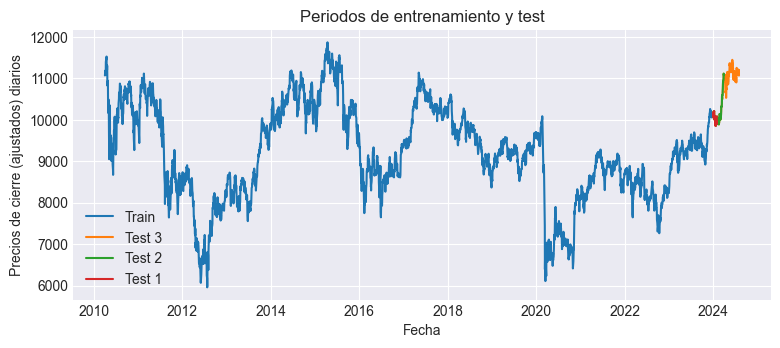

In [2]:
# Cargar los datos desde un archivo HDF5
ibex35 = pd.read_hdf('ibex35.h5', key='datos_tratados')
y = pd.DataFrame(ibex35['adj_close'])
X = ibex35.drop('adj_close', axis=1)
## TRAIN Y TEST
fin_train = '2023-12-31'
fin_test1 = '2024-01-31'
fin_test2 = '2024-03-31'
print(
    f"Fechas train : {y.index.min()} --- {y.loc[:fin_train].index.max()}  "
    f"(n={len(y.loc[:fin_train])})"
)
print(
    f"Fechas test 1 : {y.loc[fin_train:].index.min()} --- {y.loc[:fin_test1].index.max()}  "
    f"(n={len(y.loc[fin_train:fin_test1])})"
)
print(
    f"Fechas test 2 : {y.loc[fin_train:].index.min()} --- {y.loc[:fin_test2].index.max()}  "
    f"(n={len(y.loc[fin_train:fin_test2])})"
)
print(
    f"Fechas test 3 : {y.loc[fin_train:].index.min()} --- {y.loc[:].index.max()}  "
    f"(n={len(y.loc[fin_train:])})"
)
## Train
y_train = y.loc[:fin_train]
X_train = X.loc[:fin_train]

## Escenario 1
y_test1  = y.loc[fin_train:fin_test1]
X_test1  = X.loc[fin_train:fin_test1]

## Escenario 2
y_test2  = y.loc[fin_train:fin_test2]
X_test2  = X.loc[fin_train:fin_test2]

## Escenario 3
y_test3  = y.loc[fin_train:]
X_test3  = X.loc[fin_train:]


# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))

# Usar matplotlib directamente para más control sobre las etiquetas
ax.plot(y_train.index, y_train['adj_close'], label='Train')
ax.plot(y_test3.index, y_test3['adj_close'], label='Test 3')
ax.plot(y_test2.index, y_test2['adj_close'], label='Test 2')
ax.plot(y_test1.index, y_test1['adj_close'], label='Test 1')

# Títulos y etiquetas de los ejes
ax.set_title('Periodos de entrenamiento y test')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precios de cierre (ajustados) diarios')
# Mostrar leyenda
ax.legend()
# Mostrar el gráfico
plt.show()

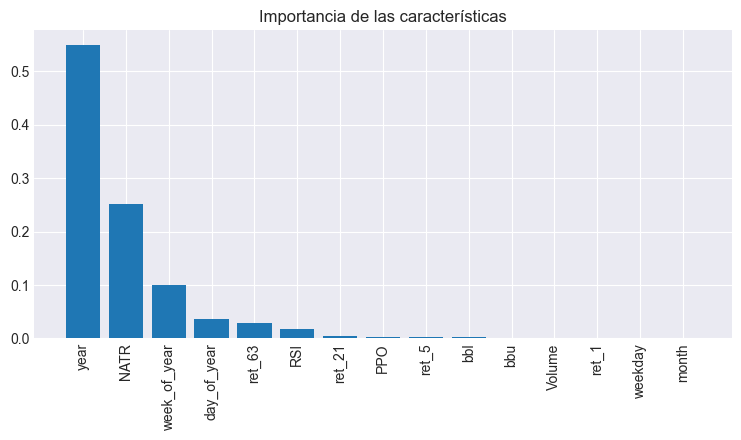

In [3]:
# Modelo XGBoost
model = XGBRegressor()

# Entrena el modelo
model.fit(X_train, y_train)

# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
columnas = X_train.columns

# Gráfico de importancia de características
plt.figure(figsize=(9, 4))
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importancias[indices], align="center")
plt.xticks(range(X_train.shape[1]), columnas[indices], rotation=90)
plt.show()


In [4]:
## Train
X_train = X_train[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]

## Escenario 1
X_test1 = X_test1[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]

## Escenario 2
X_test2 = X_test2[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]

## Escenario 3
X_test3 = X_test3[['year', 'NATR', 'week_of_year', 'day_of_year', 'ret_63']]

## 2. Construcción del modelo

In [5]:
import time
# Modelo XGBoost
model = XGBRegressor()

# Definir los hiperparámetros a ajustar
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.1, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0.01, 0.1, 0.2]
}

# inicio temporizador 
start_time = time.time() 
# Búsqueda de los parámetros óptimos
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=20, cv=8, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', random_state=42)
randomized_search.fit(X_train, y_train)

# Fin del temporizador
end_time = time.time()
total_time = end_time - start_time

print(f"Tiempo total de búsqueda: {total_time / 60:.2f} minutos")

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros:", randomized_search.best_params_)

# Modelo con los mejores hiperparámetros
best_model = randomized_search.best_estimator_

# Predicciones con el mejor modelo
y_pred1 = best_model.predict(X_test1)
y_pred2 = best_model.predict(X_test2)
y_pred3 = best_model.predict(X_test3)

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Tiempo total de búsqueda: 0.14 minutos
Mejores hiperparámetros: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}


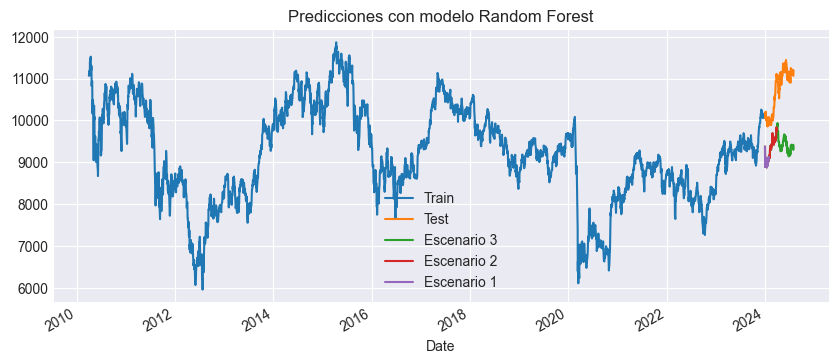

In [6]:
# Creamos Series de pandas para las predicciones
y_pred1_series = pd.Series(y_pred1, index=y_test1.index)
y_pred2_series = pd.Series(y_pred2, index=y_test2.index)
y_pred3_series = pd.Series(y_pred3, index=y_test3.index)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos los datos de entrenamiento y prueba
y_train['adj_close'].plot(ax=ax, label='Train')
y_test3['adj_close'].plot(ax=ax, label='Test')

# Graficamos las predicciones convertidas en Series
y_pred3_series.plot(ax=ax, label='Escenario 3')
y_pred2_series.plot(ax=ax, label='Escenario 2')
y_pred1_series.plot(ax=ax, label='Escenario 1')

ax.set_title('Predicciones con modelo Random Forest')
ax.legend()
plt.show()

Se observa un rendimiento muy poco satisfactorio del modelo, por lo que se ha decidido incluir características nuevas para ver cómo estas pueden afectar los resultados.

## 3. Creación de nuevas características

In [7]:
# Cargar los datos desde un archivo HDF5
df = pd.read_hdf('ibex35.h5', key='datos_tratados')

# Creo df2 con NUEVOS INDICADORES TÉCNICOS
df2 = pd.DataFrame(index=df.index)
df2['log_ret_1'] = np.log(df['adj_close'] / df['adj_close'].shift(1))
df2['log_ret_5'] = np.log(df['adj_close'] / df['adj_close'].shift(5))
df2['volatility_21'] = df['ret_1'].rolling(window=21).std()
df2['ma_200'] = df['adj_close'].rolling(window=200).mean()
exp1 = df['adj_close'].ewm(span=12, adjust=False).mean()
exp2 = df['adj_close'].ewm(span=26, adjust=False).mean()
df2['MACD'] = exp1 - exp2

# Estandarizar df2
scaler = StandardScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df2), index=df2.index, columns=df2.columns)

# Fusionar df y df2_scaled
ibex35 = pd.concat([df, df2_scaled], axis=1)
ibex35.dropna(inplace=True)

y = pd.DataFrame(ibex35['adj_close'])
X = ibex35.drop('adj_close', axis=1)
## TRAIN Y TEST
fin_train = '2023-12-31'
fin_test1 = '2024-01-31'
fin_test2 = '2024-03-31'

## Train
y_train = y.loc[:fin_train]
X_train = X.loc[:fin_train]

## Escenario 1
y_test1  = y.loc[fin_train:fin_test1]
X_test1  = X.loc[fin_train:fin_test1]

## Escenario 2
y_test2  = y.loc[fin_train:fin_test2]
X_test2  = X.loc[fin_train:fin_test2]

## Escenario 3
y_test3  = y.loc[fin_train:]
X_test3  = X.loc[fin_train:]

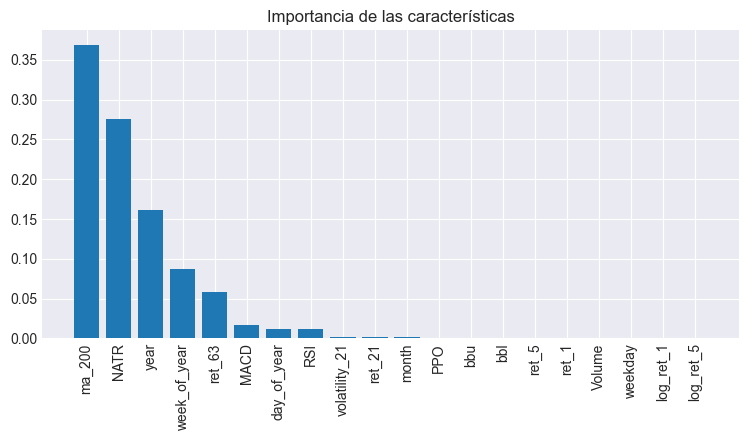

In [8]:
# Modelo XGBoost
model = XGBRegressor()

# Entrena el modelo
model.fit(X_train, y_train)

# Importancia de las características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]
columnas = X_train.columns

# Gráfico de importancia de características
plt.figure(figsize=(9, 4))
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importancias[indices], align="center")
plt.xticks(range(X_train.shape[1]), columnas[indices], rotation=90)
plt.show()

In [9]:
## Train
X_train = X_train[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Escenario 1
X_test1 = X_test1[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Escenario 2
X_test2 = X_test2[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Escenario 3
X_test3 = X_test3[['ma_200', 'NATR', 'year', 'week_of_year', 'ret_63']]

## Construcción nuevamente del modelo

In [10]:
import time
# Modelo XGBoost
model = XGBRegressor()

# Definir los hiperparámetros a ajustar
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.1, 0.7, 0.8],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0.01, 0.1, 0.2]
}

# inicio temporizador 
start_time = time.time() 
# Búsqueda de los parámetros óptimos
randomized_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=20, cv=8, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', random_state=42)
randomized_search.fit(X_train, y_train)

# Fin del temporizador
end_time = time.time()
total_time = end_time - start_time

print(f"Tiempo total de búsqueda: {total_time / 60:.2f} minutos")

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros:", randomized_search.best_params_)

# Modelo con los mejores hiperparámetros
best_model = randomized_search.best_estimator_

# Predicciones con el mejor modelo
y_pred1 = best_model.predict(X_test1)
y_pred2 = best_model.predict(X_test2)
y_pred3 = best_model.predict(X_test3)

Fitting 8 folds for each of 20 candidates, totalling 160 fits
Tiempo total de búsqueda: 0.08 minutos
Mejores hiperparámetros: {'subsample': 0.1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.7}


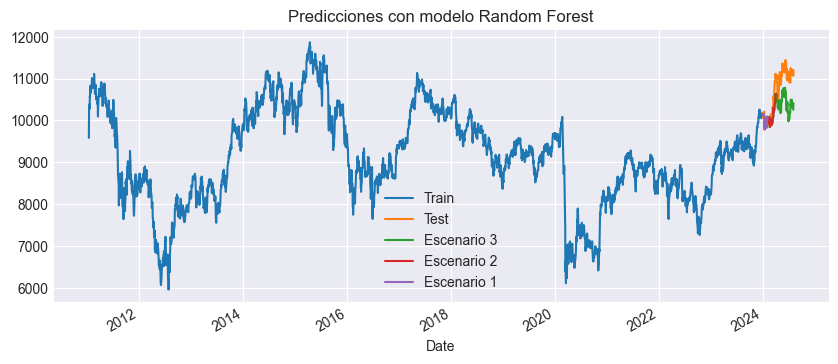

In [11]:
# Creamos Series de pandas para las predicciones
y_pred1_series = pd.Series(y_pred1, index=y_test1.index)
y_pred2_series = pd.Series(y_pred2, index=y_test2.index)
y_pred3_series = pd.Series(y_pred3, index=y_test3.index)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos los datos de entrenamiento y prueba
y_train['adj_close'].plot(ax=ax, label='Train')
y_test3['adj_close'].plot(ax=ax, label='Test')

# Graficamos las predicciones convertidas en Series
y_pred3_series.plot(ax=ax, label='Escenario 3')
y_pred2_series.plot(ax=ax, label='Escenario 2')
y_pred1_series.plot(ax=ax, label='Escenario 1')

ax.set_title('Predicciones con modelo Random Forest')
ax.legend()
plt.show()

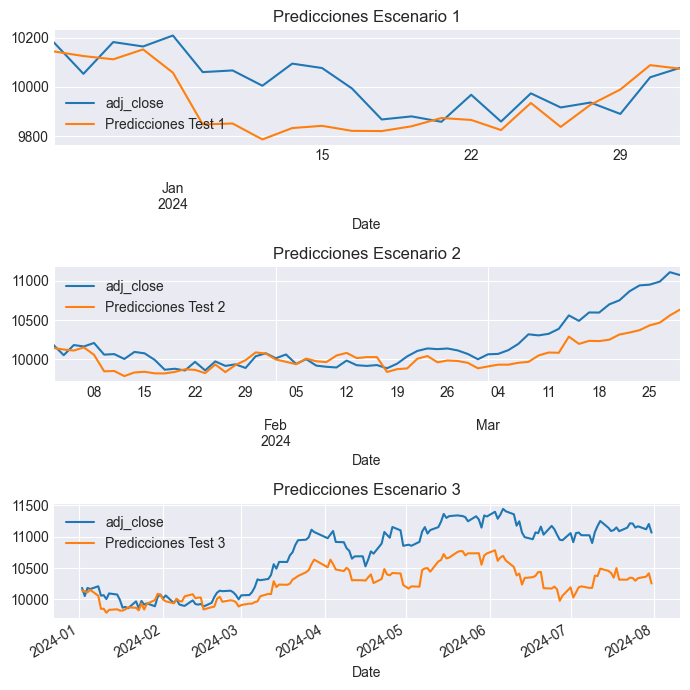

In [12]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))

# Escenario 1
y_test1.plot(ax=axes[0], label='Adj Close')
y_pred1_series.plot(ax=axes[0], label='Predicciones Test 1')
axes[0].set_title('Predicciones Escenario 1')
axes[0].legend()

# Escenario 2
y_test2.plot(ax=axes[1], label='Datos de prueba (Test 2)')
y_pred2_series.plot(ax=axes[1], label='Predicciones Test 2')
axes[1].set_title('Predicciones Escenario 2')
axes[1].legend()

# Escenario 3
y_test3.plot(ax=axes[2], label='Datos de prueba (Test 3)')
y_pred3_series.plot(ax=axes[2], label='Predicciones Test 3')
axes[2].set_title('Predicciones Escenario 3')
axes[2].legend()

# Ajustar espacio entre los subplots para que no se superpongan los títulos y etiquetas
plt.tight_layout()
plt.show()

## 3. Métricas de validación

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular métricas para predicciones de statsmodels
## ESCENARIO 1
mae_SVM = mean_absolute_error(y_test1, y_pred1_series)
mse_SVM = mean_squared_error(y_test1, y_pred1_series)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 1):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 2
mae_SVM = mean_absolute_error(y_test2, y_pred2_series)
mse_SVM = mean_squared_error(y_test2, y_pred2_series)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 2):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")
print('\n')

## ESCENARIO 3
mae_SVM = mean_absolute_error(y_test3, y_pred3_series)
mse_SVM = mean_squared_error(y_test3, y_pred3_series)
rmse_SVM = np.sqrt(mse_SVM)
print("Métricas de validación (Escenario 3):")
print(f"MAE: {mae_SVM:.4f}")
print(f"MSE: {mse_SVM:.4f}")
print(f"RMSE: {rmse_SVM:.4f}")

Métricas de validación (Escenario 1):
MAE: 98.9841
MSE: 16514.2675
RMSE: 128.5079


Métricas de validación (Escenario 2):
MAE: 179.2690
MSE: 55911.6926
RMSE: 236.4565


Métricas de validación (Escenario 3):
MAE: 459.3621
MSE: 294775.7488
RMSE: 542.9325
